# See the diff of (h-bond or non-h-bond) b/w strong and week attention by each head

- hbond combination / Attention strong combination.
- hbond combination / all combination.

In [1]:
%config IPCompleter.use_jedi=False

In [2]:
import os
import subprocess
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
from analysis_util import calc_melt_df
from matplotlib import pyplot as plt
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import sys
sys.path.append('../streamlit/')
from streamlit_utils import STD_THH, get_attention_and_hhb_relationship
from scipy.stats import ttest_ind_from_stats

flatten = lambda xlist: [x for xx in xlist for x in xx]
pickleload = lambda p: pickle.load(open(p,"rb"))



loading....


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

ending... loading....


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]
25it [00:00, 56.81it/s]

2OL3 has only delta-chain and beta-chain


62it [00:01, 48.86it/s]

4QRR has only delta-chain and beta-chain
5JHD has only delta-chain and beta-chain
5JZI has only delta-chain and beta-chain


79it [00:01, 52.30it/s]
/Users/kyoheikoyama/.pyenv/versions/miniconda3-latest/envs/tcrpred/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [3]:
pd.options.display.float_format = '{:.5g}'.format

In [4]:
%%time

print('STD_THH =', STD_THH)

HEAD_COUNT = 4


# New

distance_path = './residue_distances.parquet'

if os.path.exists(distance_path):
    df_distance = pd.read_parquet(distance_path)
else:
    DATETIME = '20220211_191954'
    DICT_PDBID_2_MELTDIST = pickleload(
        f"/Users/kyoheikoyama/workspace/tcrpred/analysis/DICT_PDB_Result/{DATETIME}_DICT_PDBID_2_MELTDIST_allatoms.pickle"
    )

    df_distance = pd.concat([df.assign(pdbid=k) for k,df in DICT_PDBID_2_MELTDIST.items()])
    df_distance.to_parquet(distance_path)


STD_THH = 5.0
CPU times: user 67.6 ms, sys: 23.5 ms, total: 91.1 ms
Wall time: 124 ms


In [5]:
# NEEDED_PDBIDS = ["2VLK", "5WKF", "3PQY", "4MJI", "4P2Q", "2YPL", "1J8H, 4P2R", "5MEN", "3MV8", "3VXR",
#                  "3VXS", "5TEZ", "2J8U", "6Q3S", "4JRX", "1U3H", "4JRY", "4Z7V", "4JFE", "4JFD", "3QIU", "2Z31",
#                  "2BNR", "3MBE", "4OZH", "2NX5", "5NHT", "4QOK", "5D2L", "1D9K", "4P2O", "5WKH", "6EQB", "2VLR"]

NEEDED_PDBIDS = ["2VLK","5WKF","3PQY","4MJI","4P2Q","2YPL","1J8H","4P2R","5MEN","3MV8","3VXR","3VXS",
                 "5TEZ","2J8U","6Q3S","4JRX","1U3H","4JRY","4Z7V","4JFE","4JFD","3QIU","2Z31","2BNR",
                 "3MBE","4OZH","2NX5","5NHT","4QOK","5D2L","1D9K","4P2O","5WKH","6EQB","2VLR"]


In [6]:
!ls ./DICT_PDB_Result/

2021_DICT_PDBID_2_Atten12.pickle
2021_DICT_PDBID_2_CDRS.pickle
2021_DICT_PDBID_2_CHAINNAMES.pickle
2021_DICT_PDBID_2_DISTANCE.pickle
2021_DICT_PDBID_2_MELTDIST.pickle
2021_DICT_PDBID_2_RESIDUES.pickle
2021_DICT_PDBID_2_SEQUENCES_CDR.pickle
2021_DICT_PDBID_2_dfhhb.pickle
2021_DICT_PDBID_2_dfnnb.pickle
2021_DICT_PDBID_2_model_out.pickle
20220211_191954_DICT_PDBID_2_Atten12.pickle
20220211_191954_DICT_PDBID_2_CDRS.pickle
20220211_191954_DICT_PDBID_2_CHAINNAMES.pickle
20220211_191954_DICT_PDBID_2_DISTANCE.pickle
20220211_191954_DICT_PDBID_2_MELTDIST.pickle
20220211_191954_DICT_PDBID_2_MELTDIST_CAatom.pickle
20220211_191954_DICT_PDBID_2_MELTDIST_allatoms.pickle
20220211_191954_DICT_PDBID_2_RESIDUES.pickle
20220211_191954_DICT_PDBID_2_SEQUENCES_CDR.pickle
20220211_191954_DICT_PDBID_2_dfhhb.pickle
20220211_191954_DICT_PDBID_2_model_out.pickle


In [7]:
def show_correlation(merged_xy_1, merged_xy_2, head):
    #merged_xy_1, merged_xy_2 = calc_melt_df(distmat_vis, attn_output_weights2, attn_output_weights1)
    assert len(merged_xy_2)!=0
    assert len(merged_xy_1)!=0
    x = merged_xy_2['value_x'].values
    y = merged_xy_2['value_y'].values
    b2, m2 = polyfit(x, y, 1)
    axs[0, head].plot(x, b2 + m2 * x, '-')
    axs[0, head].scatter(x, y)
    axs[0, head].set_xlabel('distance in PDB')
    axs[0, head].set_ylabel('attention weight value')
    axs[0, head].set_title(f'correlation b/w distance and attention \n (given a PEP, distribute tcr values to the sum 1.0), head {head} \n y={b2:.3f}+{m2:.3f}* x')
    
    x = merged_xy_1['value_x'].values
    y = merged_xy_1['value_y'].values
    b1, m1 = polyfit(x, y, 1)
    axs[1, head].plot(x, b1 + m1 * x, '-')
    axs[1, head].scatter(x, y)
    axs[1, head].set_xlabel('distance in PDB')
    axs[1, head].set_ylabel('attention weight value')
    axs[1, head].set_title(f'correlation b/w distance and attention \n (given a TCR, distribute pep values to the sum 1.0), head {head} \n y={b1:.3f}+{m1:.3f}* x')
    return (b1,m1,b2,m2)
    

# Only more than x sigma and PosPred Attention 

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


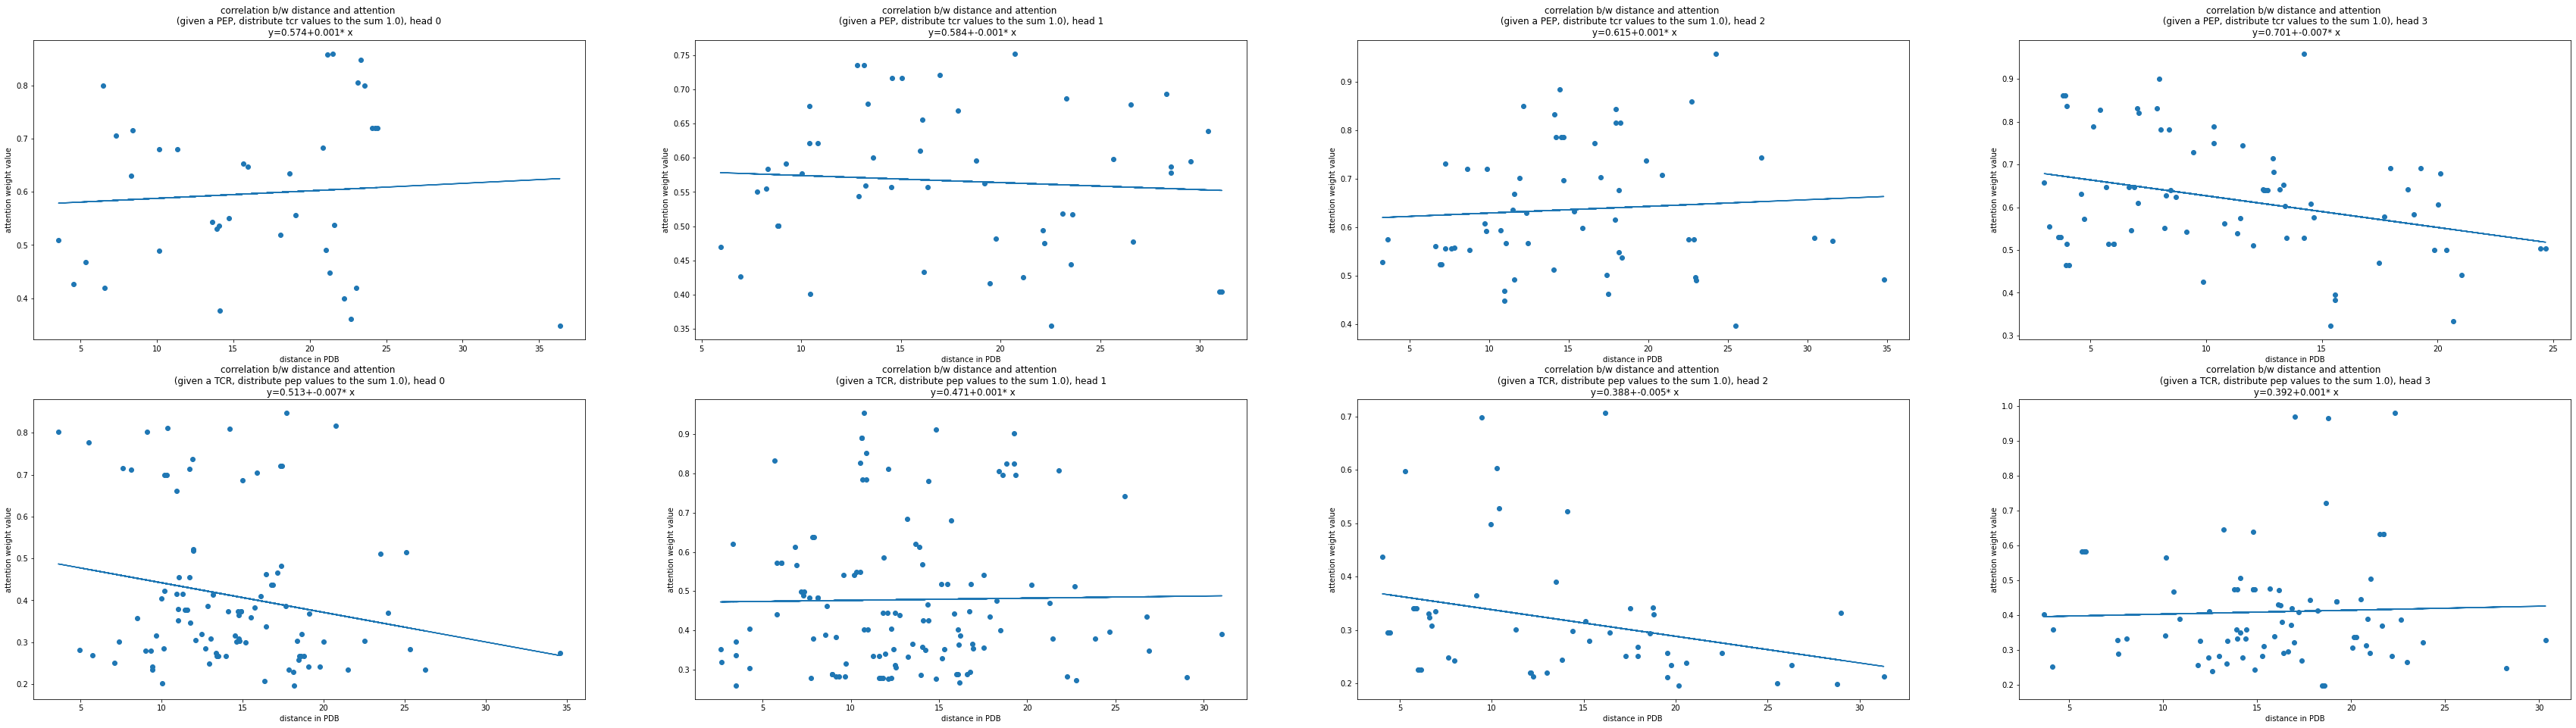

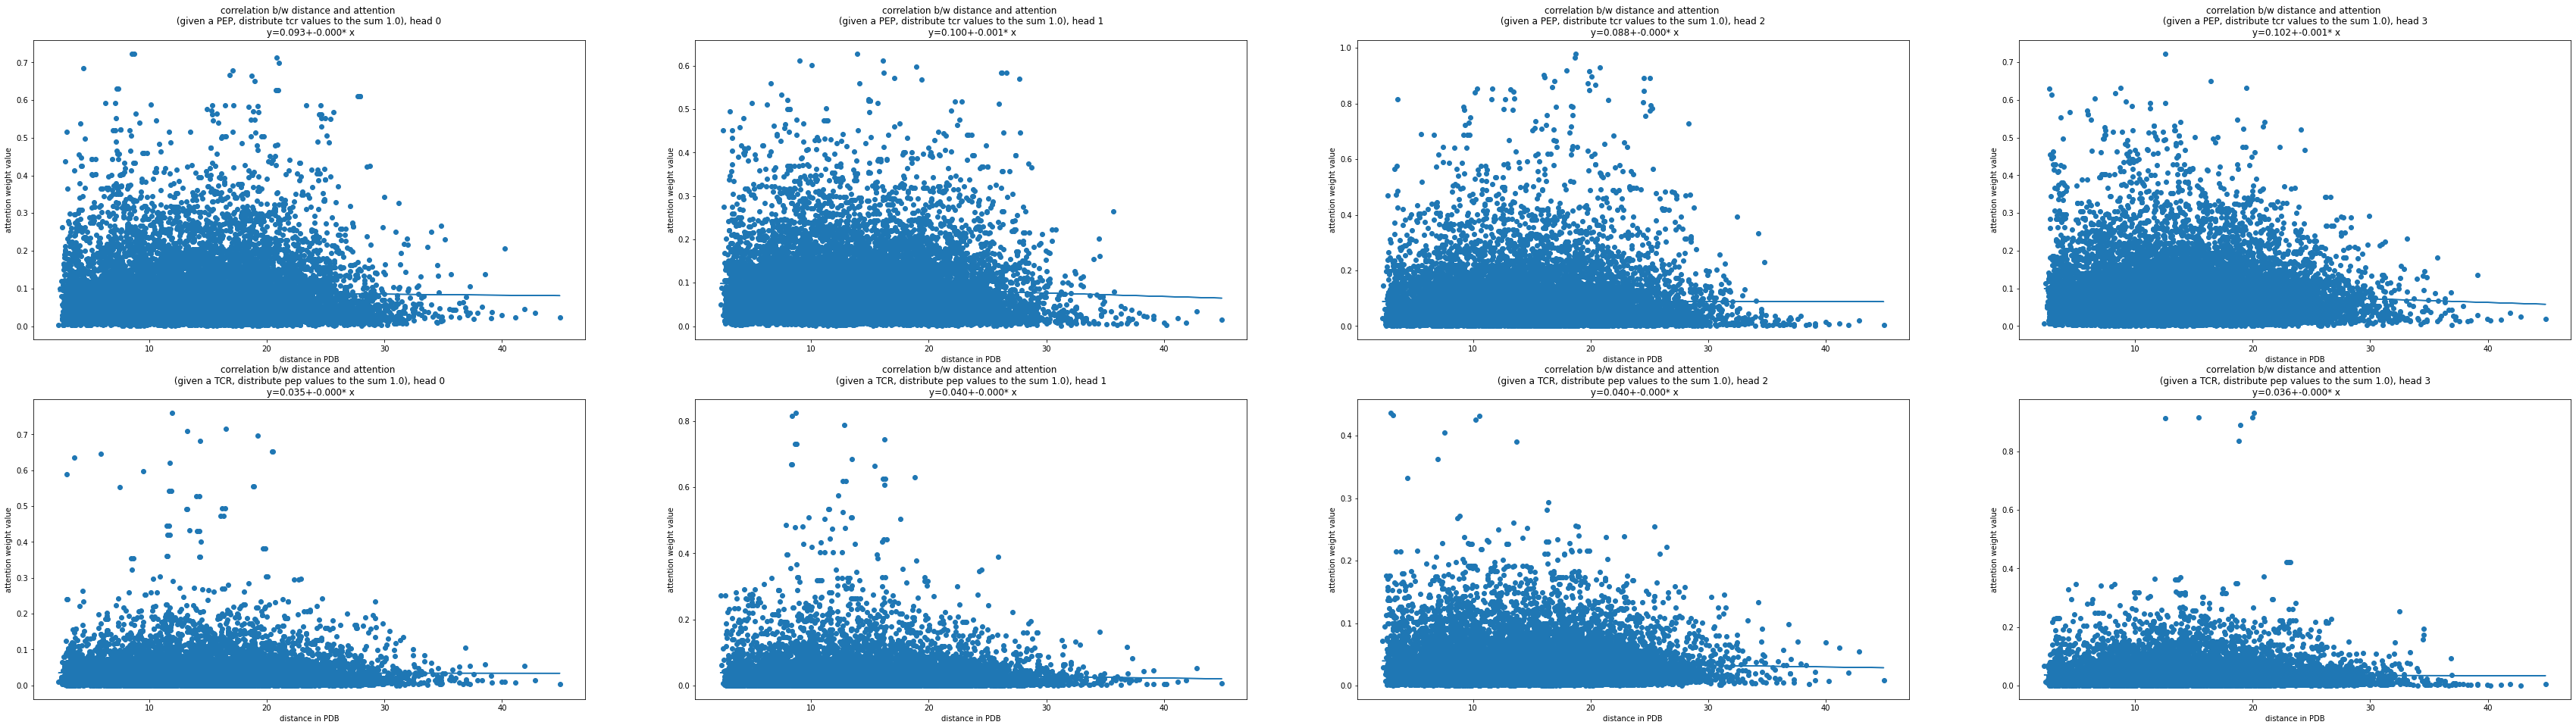

In [8]:
givenPEP_distributedTCR_by_head_large, givenTCR_distributedPEP_by_head_large =\
get_attention_and_hhb_relationship(strong_atten=True)

fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
for hi in range(4):
    _temp_df1_strong_atten = pd.concat(givenPEP_distributedTCR_by_head_large[hi])
    _temp_df2_strong_atten = pd.concat(givenTCR_distributedPEP_by_head_large[hi])
    show_correlation(_temp_df1_strong_atten, _temp_df2_strong_atten, hi)



df1_strong_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head_large[hi] for hi in range(4)])) 
df2_strong_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head_large[hi] for hi in range(4)]))

givenPEP_distributedTCR_by_head, givenTCR_distributedPEP_by_head =\
get_attention_and_hhb_relationship(strong_atten=False)

fig, axs = plt.subplots(2, HEAD_COUNT, figsize=(60,16))
for hi in range(4):
    _temp_df1_normal_atten = pd.concat(givenPEP_distributedTCR_by_head[hi])
    _temp_df2_normal_atten = pd.concat(givenTCR_distributedPEP_by_head[hi])
    show_correlation(_temp_df1_normal_atten, _temp_df2_normal_atten, hi)

    
df1_normal_atten = pd.concat(flatten([givenPEP_distributedTCR_by_head[hi] for hi in range(4)])) 
df2_normal_atten = pd.concat(flatten([givenTCR_distributedPEP_by_head[hi] for hi in range(4)]))


# Add minimum distance

In [9]:
dist_tcr_side = pd.merge(df_distance[['pdbid','tcr', 'value']].groupby(['pdbid','tcr'], as_index=False).min(), 
         df_distance, 
         on=['pdbid','tcr', 'value'],
        ).rename(columns={'value':'distance_value', 'peptide':'peptide_min'})

dist_peptide_side = pd.merge(df_distance[['pdbid','peptide', 'value']].groupby(['pdbid','peptide'], as_index=False).min(), 
         df_distance, 
         on=['pdbid','peptide', 'value'],
        ).rename(columns={'value':'distance_value', 'tcr':'tcr_min'})


df1_strong_atten = pd.merge(df1_strong_atten, dist_tcr_side, on=['pdbid','tcr'], how='left')
df1_normal_atten = pd.merge(df1_normal_atten, dist_tcr_side, on=['pdbid','tcr'], how='left' )
df2_strong_atten = pd.merge(df2_strong_atten, dist_peptide_side, on=['pdbid','peptide'], how='left' )
df2_normal_atten = pd.merge(df2_normal_atten, dist_peptide_side, on=['pdbid','peptide'], how='left' )


df1_normal_atten = df1_normal_atten[
    ~df1_normal_atten[['pdbid','tcr']].apply(tuple,axis=1).isin(
        (df1_strong_atten[['pdbid','tcr']].apply(tuple,axis=1)))
]

df2_normal_atten = df2_normal_atten[
    ~df2_normal_atten[['pdbid','peptide']].apply(tuple,axis=1).isin(
        (df2_strong_atten[['pdbid','peptide']].apply(tuple,axis=1)))
]

# Compare Distances

## Take the min by each head

In [10]:

for hi in range(4):
    print('head =', hi)
    stats = pd.concat([
        df1_strong_atten.query(f'head=={hi}').groupby(['pdbid', 'tcr', ]).min().reset_index().distance_value.describe([0.5]), 
        df1_normal_atten.query(f'head=={hi}').groupby(['pdbid', 'tcr', ]).min().reset_index().distance_value.describe([0.5]),
        df2_strong_atten.query(f'head=={hi}').groupby(['pdbid', 'peptide', ]).min().reset_index().distance_value.describe([0.5]), 
        df2_normal_atten.query(f'head=={hi}').groupby(['pdbid', 'peptide', ]).min().reset_index().distance_value.describe([0.5]),], axis=1)

    stats.columns = [
        'Large Attention of TCRs', 
        'Small Attention of TCRs', 
        'Large Attention of Peptides', 
        'Small Attention of Peptides', 
                    ]
    display(stats.rename(index={'50%':'median'}))
    
    describe_series1 = df1_strong_atten.query(f'head=={hi}').groupby(['pdbid', 'tcr', ]).min().reset_index().distance_value.describe([0.5])
    mean1 = describe_series1.loc['mean']
    std1 = describe_series1.loc['std']
    nobs1=len(df1_strong_atten)

    describe_series2 = df1_normal_atten.query(f'head=={hi}').groupby(['pdbid', 'tcr', ]).min().reset_index().distance_value.describe([0.5])
    mean2 = describe_series2.loc['mean']
    std2 = describe_series2.loc['std']
    nobs2=len(df1_normal_atten)

    print(f'  head={hi} TCR side',
        ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                         mean2=mean2, std2=std2, nobs2=nobs2)
    )

    describe_series1 = df2_strong_atten.query(f'head=={hi}').groupby(['pdbid', 'peptide', ]).min().reset_index().distance_value.describe([0.5])
    mean1 = describe_series1.loc['mean']
    std1 = describe_series1.loc['std']
    nobs1=len(df2_strong_atten)

    describe_series2 = df2_normal_atten.query(f'head=={hi}').groupby(['pdbid', 'peptide', ]).min().reset_index().distance_value.describe([0.5])
    mean2 = describe_series2.loc['mean']
    std2 = describe_series2.loc['std']
    nobs2=len(df2_normal_atten)

    print(f'  head={hi} PEP side',
        ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                         mean2=mean2, std2=std2, nobs2=nobs2)
    )    

head = 0


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,50,1067,30,383
mean,8.9564,8.3702,5.397,5.2464
std,3.4028,4.5708,3.2803,2.7512
min,2.9865,2.3739,2.61,2.2843
median,8.1338,7.4762,4.2625,4.3011
max,18.764,19.575,19.747,24.261


  head=0 TCR side Ttest_indResult(statistic=2.404386417878777, pvalue=0.016203453441096447)
  head=0 PEP side Ttest_indResult(statistic=0.8089307963126938, pvalue=0.41855963364821)
head = 1


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,62,1067,40,383
mean,7.5434,8.3702,5.1207,5.2464
std,3.7158,4.5708,2.4093,2.7512
min,2.2843,2.3739,2.505,2.2843
median,7.1349,7.4762,3.4555,4.3011
max,17.474,19.575,8.7408,24.261


  head=1 TCR side Ttest_indResult(statistic=-3.390297366000828, pvalue=0.0006987380335077394)
  head=1 PEP side Ttest_indResult(statistic=-0.6762294241533138, pvalue=0.4988987968898224)
head = 2


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,36,1067,37,383
mean,7.9548,8.3702,4.5441,5.2464
std,4.6465,4.5708,2.3053,2.7512
min,2.505,2.3739,2.505,2.2843
median,6.2343,7.4762,3.5162,4.3011
max,17.61,19.575,12.272,24.261


  head=2 TCR side Ttest_indResult(statistic=-1.7011371047687, pvalue=0.08892380825368143)
  head=2 PEP side Ttest_indResult(statistic=-3.77914670224412, pvalue=0.0001575886694845092)
head = 3


,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,55,1067,47,383
mean,8.0851,8.3702,3.9703,5.2464
std,3.6959,4.5708,1.6453,2.7512
min,2.2843,2.3739,2.6602,2.2843
median,9.2792,7.4762,3.4222,4.3011
max,15.367,19.575,9.9072,24.261


  head=3 TCR side Ttest_indResult(statistic=-1.1693407709568813, pvalue=0.24227224699896088)
  head=3 PEP side Ttest_indResult(statistic=-6.873160258668751, pvalue=6.368827096788981e-12)


## Take all the possible combinations

In [11]:

# for hi in range(4):
#     print()
#     print()
#     print('head =', hi)
#     stats = pd.concat([
#         df1_strong_atten.query(f'head=={hi}').distance_value.describe([0.5]), 
#         df1_normal_atten.query(f'head=={hi}').distance_value.describe([0.5]),
#         df2_strong_atten.query(f'head=={hi}').distance_value.describe([0.5]), 
#         df2_normal_atten.query(f'head=={hi}').distance_value.describe([0.5]),], axis=1)

#     stats.columns = [
#         'Large Attention of TCRs', 
#         'Small Attention of TCRs', 
#         'Large Attention of Peptides', 
#         'Small Attention of Peptides', 
#                     ]
#     display(stats.rename(index={'50%':'median'}))
    
#     describe_series1 = df1_strong_atten.query(f'head=={hi}').distance_value.describe([0.5])
#     mean1 = describe_series1.loc['mean']
#     std1 = describe_series1.loc['std']
#     nobs1=len(df1_strong_atten)

#     describe_series2 = df1_normal_atten.query(f'head=={hi}').distance_value.describe([0.5])
#     mean2 = describe_series2.loc['mean']
#     std2 = describe_series2.loc['std']
#     nobs2=len(df1_normal_atten)

#     print(f'  head={hi} TCR side',
#         ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
#                          mean2=mean2, std2=std2, nobs2=nobs2)
#     )
#     describe_series1 = df2_strong_atten.query(f'head=={hi}').distance_value.describe([0.5])
#     mean1 = describe_series1.loc['mean']
#     std1 = describe_series1.loc['std']
#     nobs1=len(df2_strong_atten)

#     describe_series2 = df2_normal_atten.query(f'head=={hi}').distance_value.describe([0.5])
#     mean2 = describe_series2.loc['mean']
#     std2 = describe_series2.loc['std']
#     nobs2=len(df2_normal_atten)

#     print(f'  head={hi} PEP side',
#         ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
#                          mean2=mean2, std2=std2, nobs2=nobs2)
#     )    

# Minimum distance dataframe

In [12]:
min_df1_strong_atten = df1_strong_atten.groupby(['pdbid', 'tcr', ]).min().reset_index()
min_df1_normal_atten = df1_normal_atten.groupby(['pdbid', 'tcr', ]).min().reset_index()
min_df2_strong_atten = df2_strong_atten.groupby(['pdbid', 'peptide', ]).min().reset_index()
min_df2_normal_atten = df2_normal_atten.groupby(['pdbid', 'peptide', ]).min().reset_index()

stats = pd.concat([
    min_df1_strong_atten.distance_value.describe([0.5]), 
    min_df1_normal_atten.distance_value.describe([0.5]),
    min_df2_strong_atten.distance_value.describe([0.5]), 
    min_df2_normal_atten.distance_value.describe([0.5]),], axis=1)

stats.columns = [
    'Large Attention of TCRs', 
    'Small Attention of TCRs', 
    'Large Attention of Peptides', 
    'Small Attention of Peptides', 
                ]
display(stats.rename(index={'50%':'median'}))


describe_series1 = min_df1_strong_atten.distance_value.describe([0.5])
mean1 = describe_series1.loc['mean']
std1 = describe_series1.loc['std']
nobs1=len(min_df1_strong_atten)

describe_series2 = min_df1_normal_atten.distance_value.describe([0.5])
mean2 = describe_series2.loc['mean']
std2 = describe_series2.loc['std']
nobs2=len(min_df1_normal_atten)

print('  TCR side =',
    ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                     mean2=mean2, std2=std2, nobs2=nobs2)
)

describe_series1 = min_df2_strong_atten.distance_value.describe([0.5])
mean1 = describe_series1.loc['mean']
std1 = describe_series1.loc['std']
nobs1=len(min_df2_strong_atten)

describe_series2 = min_df2_normal_atten.distance_value.describe([0.5])
mean2 = describe_series2.loc['mean']
std2 = describe_series2.loc['std']
nobs2=len(min_df2_normal_atten)

print('  PEP side =',
    ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                     mean2=mean2, std2=std2, nobs2=nobs2)
)

,Large Attention of TCRs,Small Attention of TCRs,Large Attention of Peptides,Small Attention of Peptides
count,187,1067,135,383
mean,7.9755,8.3702,4.6955,5.2464
std,3.731,4.5708,2.4684,2.7512
min,2.2843,2.3739,2.505,2.2843
median,7.3773,7.4762,3.5372,4.3011
max,18.764,19.575,19.747,24.261


  TCR side = Ttest_indResult(statistic=-1.1173539163622446, pvalue=0.2640573986446187)
  PEP side = Ttest_indResult(statistic=-2.05324539623739, pvalue=0.04055234220922599)
